In [136]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
#from pylab import rcParams
#rcParams['figure.figsize'] = 15, 6

class Opinion:
    
    @classmethod
    def getDataByDateRange(self, data, fromDate, toDate):
        data = data[( pd.to_datetime(data['datetime']) >= fromDate) & ( pd.to_datetime(data['datetime']) <= toDate) ]
        return data
    
    @classmethod
    def orderData(self, data, by, tureOrFalse=True):
        #by : Name or list of names which refer to the axis items
        #Ascending by default
        data = data.sort_values(by, ascending=tureOrFalse)
        return data
        
    @classmethod
    def vaderCategorize(self, data):
        #categorizing based on value ranges given in paper
        values = pd.cut(data["VADER"], bins=[-1.1, -0.61, -0.21, 0.19, 0.59,1], 
                    labels=["very nagative","negative","neutral", "positive", "very positive"] )
        #create new column category and assign values
        data["category"] = str('')
        data["category"] = values
        return data
        
    @classmethod
    def getCommentsByCat(self, data, cat):   
        #get only positive rows
        data = data.loc[data["category"] == cat]
        return data
    
    @classmethod
    def groupBy(self, data, col, operation="sum"):   
        #get only positive rows
        if(operation == "sum"):
            data = data.groupby([col], sort=False).sum().reset_index()
        if(operation == "mean"):
            data = data.groupby([col], sort=False).mean().reset_index()
        return data
    
    @classmethod
    def zscore(self, data, cols):
        print(cols)
        rownew = []
        for index, row in data.iterrows(): 
            fromDate = pd.to_datetime(row['datetime']-datetime.timedelta(10))
            toDate = pd.to_datetime(row['datetime'])
            #print(fromDate, toDate)
            
            if(fromDate <= pd.to_datetime('11/22/2009')):
                fromDate = pd.to_datetime('11/22/2009')
                
            data4 = self.getDataByDateRange(data, fromDate, toDate)
            
            colgrp = []
            for col in cols:
                col_zscore = 'zscore_'+col
                if data4[col].std(ddof=0) == 0.0 : continue;
                zscore = (row[col] - data4[col].mean()) / data4[col].std(ddof=0)
                colgrp.append(zscore)
            rownew.append(colgrp)    
                        
        data = pd.DataFrame(rownew, columns=[col_zscore])
        return data
    
    @classmethod
    def zscore2(self, data, cols):
        for col in cols:
            col_zscore = 'zscore_'+col
            zscore = (data[col] - data[col].mean()) / data[col].std(ddof=0)         
        return zscore
    
    @classmethod
    def plotData(cls, x, y, colour, x1='', y1='', colour1=''):
        # makes numpy array
        #r = data.values.view(np.recarray)
        #grab y-datas
        #y = r[:,1]
        #crops to dates
        #x = r[:,0]
        fig, ax = plt.subplots(figsize=(15, 7))
        if len(x1) > 1:
            ax.plot_date(x, y,  fmt=colour)
            ax.plot_date(x1, y1,  fmt=colour1)
        else:
            ax.plot_date(x, y,  fmt=colour)
            
        
        fig.autofmt_xdate()
        # For tickmarks and ticklabels every week
        ax.xaxis.set_major_locator(WeekdayLocator(byweekday=MO))
        # For tickmarks and ticklabels every other week
        ax.xaxis.set_major_locator(WeekdayLocator(byweekday=MO, interval=1))

        plt.grid(True)
        plt.show()

opinion = Opinion()
print('loading')   
data = pd.read_excel('bitcoin/bitcoin_reply_xl.xlsx', 'bitcoin_reply_xl')
data['datetime'] = pd.to_datetime(data['date'])
#order data, by, true=asc, false=desc
data = Opinion.orderData(data, 'datetime', bool(0))
data.head(4)

loading


,date,reply,VADER,datetime
20970,2016-02-01,I disagree. What about in a couple years and t...,0.2484,2016-02-01
8425,2016-02-01,did you use that address for faucets or exchan...,0.0000,2016-02-01
8419,2016-02-01,It's the CIA's business to stay on top of worl...,0.6486,2016-02-01
8420,2016-02-01,Snowden is no turncoat. he's a turnturncoat. P...,-0.5093,2016-02-01


In [137]:
##Computing zscore
#five categories 
AllCatData = Opinion.vaderCategorize(data)
#print(AllCatData.head(1))

#get comment by category, i.e very positive to very negative
filteredComments = Opinion.getCommentsByCat(AllCatData, 'positive')
#filteredComments.head(30)

#summing vader of comments by date
summedVaderComments = Opinion.groupBy(filteredComments, 'datetime', 'sum')
#summedVaderComments.head(10)

#zscore of VADER column
cols = list()
cols.insert(0,'VADER')
zscore = Opinion.zscore2(summedVaderComments, cols)

#summedVaderComments['zscore_reply'] = float('NaN')
summedVaderComments['zscore_reply'] = zscore
summedVaderComments.head(3)



,datetime,VADER,zscore_reply
0,2016-02-01,89.5349,3.052278
1,2016-01-31,80.3750,2.641796
2,2016-01-30,89.5305,3.052081


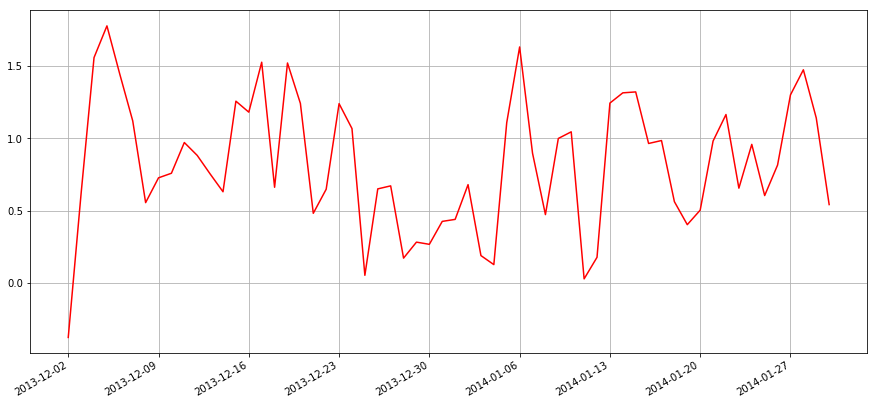

In [138]:
data2014_2013 = Opinion.getDataByDateRange(summedVaderComments, '2013-12-2', '2014-01-30')
data2013_2014 =  Opinion.orderData(data2014_2013, 'datetime')
#data2013_2014.head(5)
x1 = data2013_2014["datetime"].values
y1 = data2013_2014["zscore_reply"].values
Opinion.plotData(x1, y1, 'r')

In [139]:
# bitcoin price data
bitcoinPricedata = pd.read_excel('bitcoin/bitcoin_price.xlsx', 'bitcoin_price')
bitcoinPricedata['datetime'] = pd.to_datetime(bitcoinPricedata['Date'])
#order data, by, true=asc, false=desc
bitcoinPricedata = Opinion.orderData(bitcoinPricedata, 'datetime', bool(0))
bitcoinPricedata.head(3)

#zscore bitcoin price
cols = list()
cols.insert(0,'close_price')

zscore = Opinion.zscore2(bitcoinPricedata, cols)
#bitcoinPricedata['btc_zscore'] = float('NaN')
bitcoinPricedata['zscore_btc'] = zscore

data2014_2013_btc = Opinion.getDataByDateRange(bitcoinPricedata, '2013-12-1', '2014-01-30')
data2013_2014_btc =  Opinion.orderData(data2014_2013_btc, 'datetime')

data2013_2014_btc.head(3)

,Date,close_price,datetime,zscore_btc
0,2013-12-01,946.92,2013-12-01,2.878020
1,2013-12-02,1038.35,2013-12-02,3.373320
2,2013-12-03,1068.67,2013-12-03,3.537572


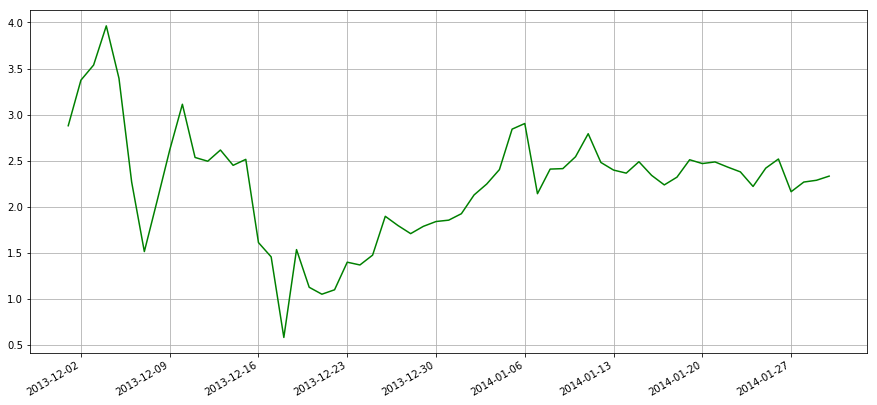

In [140]:
x = data2013_2014_btc["datetime"].values
y = data2013_2014_btc["zscore_btc"].values

Opinion.plotData(x, y, 'g')

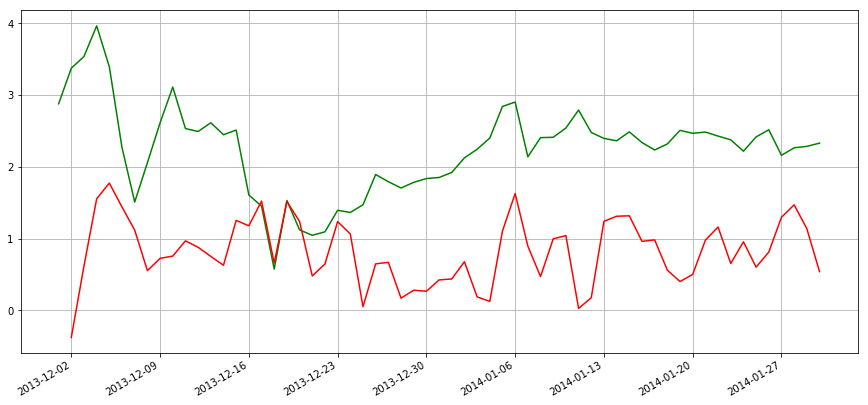

In [141]:
Opinion.plotData(x, y,  'g', x1, y1,  'r')


In [142]:
zscore_comments2016_2013 = Opinion.getDataByDateRange(summedVaderComments, '2013-12-1', '2016-2-1')
zscore_2016_2013_btc = Opinion.getDataByDateRange(bitcoinPricedata, '2013-12-1', '2016-1-28')

zscore_comments =  Opinion.orderData(zscore_comments2016_2013, 'datetime')
zscore_btc =  Opinion.orderData(zscore_2016_2013_btc, 'datetime')

xa = pd.DataFrame()
xa['btc_zscore']   = zscore_btc['zscore_btc'].values
xa['zscore_reply']  = zscore_comments['zscore_reply'].values
#making n*2 matrix, second column contains the opinion data which granger causes data(btc price) in first column
A =  np.array(xa)

#granger causelity.
from statsmodels.tsa.stattools  import   grangercausalitytests
#statsmodels.tsa.stattools.grangercausalitytests(x, 6, addconst=True, verbose=True)
grangercausalitytests(A, maxlag=13, addconst=True, verbose=True)

C:\Users\Sajid\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1808  , p=0.0131  , df_denom=785, df_num=1
ssr based chi2 test:   chi2=6.2044  , p=0.0127  , df=1
likelihood ratio test: chi2=6.1801  , p=0.0129  , df=1
parameter F test:         F=6.1808  , p=0.0131  , df_denom=785, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2265  , p=0.0149  , df_denom=782, df_num=2
ssr based chi2 test:   chi2=8.5071  , p=0.0142  , df=2
likelihood ratio test: chi2=8.4614  , p=0.0145  , df=2
parameter F test:         F=4.2265  , p=0.0149  , df_denom=782, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9558  , p=0.0317  , df_denom=779, df_num=3
ssr based chi2 test:   chi2=8.9472  , p=0.0300  , df=3
likelihood ratio test: chi2=8.8967  , p=0.0307  , df=3
parameter F test:         F=2.9558  , p=0.0317  , df_denom=779, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.4664  , p=0.0000  

{1: ({'lrtest': (6.1801125310948919, 0.012919406001160885, 1),
   'params_ftest': (6.1807897973430075, 0.013121411305405605, 785.0, 1),
   'ssr_chi2test': (6.2044106500716509, 0.012743237079660751, 1),
   'ssr_ftest': (6.1807897973429524, 0.013121411305405605, 785.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (8.4614229771755163, 0.014542040371069482, 2),
   'params_ftest': (4.2265127045492319, 0.014938212338646338, 782.0, 2),
   'ssr_chi2test': (8.5070728861388289, 0.014213878350115554, 2),
   'ssr_ftest': (4.2265127045492781, 0.014938212338645184, 782.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (8.896686087580747, 0.030696510245010022, 3),
   'params_ftest': (2.9558481457789356, 0.031737651429378545, 779.0, 3),
   'ssr_chi2test': (8.9472271216255397, 0.030000821781096421, 3),
   'ssr_ftest': (2.9558481457787509, 0.031737651429386171, 779.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0., 

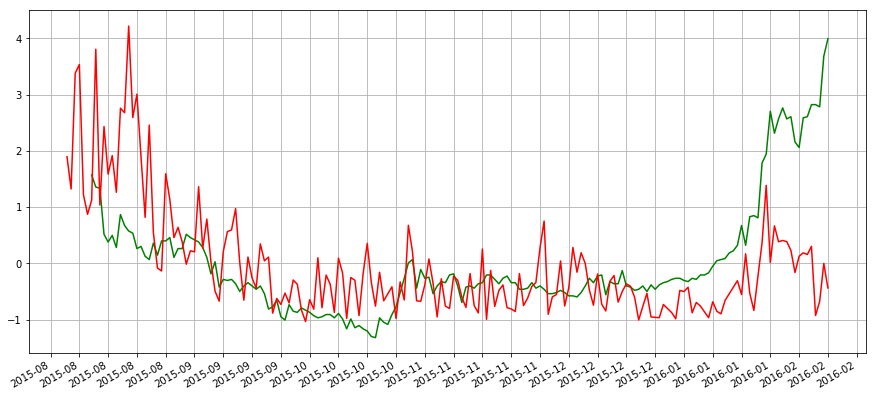

In [103]:
# Ethereum price data
import pandas as pd
etherPricedata = pd.read_csv('ethereum/ether-price.csv')
etherPricedata['datetime'] = pd.to_datetime(etherPricedata['Date'])

#order data, by, true=asc, false=desc
etherPricedata = Opinion.orderData(etherPricedata, 'datetime', bool(0))
etherPricedata = Opinion.getDataByDateRange(etherPricedata, '2015-08-13', '2016-02-8')
#zscore ether price
cols = list()
cols.insert(0,'Value')
zscore = Opinion.zscore2(etherPricedata, cols)
etherPricedata['zscore_eth'] = zscore
#etherPricedata
x = etherPricedata['datetime'].values
y = etherPricedata['zscore_eth'].values

#Ethereum reply Data
data = pd.read_csv('ethereum/ethereum_reply.csv')
data['datetime'] = pd.to_datetime(data['date'])
#order data, by, true=asc, false=desc
data = Opinion.orderData(data, 'datetime', bool(0))
data = Opinion.getDataByDateRange(data, '2015-08-7', '2016-02-8')


#five categories 
AllCatData = Opinion.vaderCategorize(data)

#get comment by category, i.e very positive to very negative
filteredComments = Opinion.getCommentsByCat(AllCatData, 'positive')
#filteredComments.head(30)

#summing vader of comments by date
summedComments = Opinion.groupBy(filteredComments, 'datetime', 'sum')
#summedTopics
#zscore ether price
cols = list()
cols.insert(0,'VADER')
zscore = Opinion.zscore2(summedComments, cols)
summedComments['zscore_reply'] = zscore
#etherPricedata
#
x1 = summedComments['datetime'].values
y1 = summedComments['zscore_reply'].values
#
Opinion.plotData(x, y, 'g', x1, y1, 'r')

In [106]:
#etherTransdata = Opinion.getDataByDateRange(etherTransdata, '2013-12-1', '2016-2-1')
#etherPricedata = Opinion.getDataByDateRange(etherPricedata, '2013-12-1', '2016-2-1')

summedComments =  Opinion.orderData(summedComments, 'datetime')
etherPricedata =  Opinion.orderData(etherPricedata, 'datetime')

xa = pd.DataFrame()
xa['zscore_eth']  = etherPricedata['zscore_eth'].values
xa['zscore_reply']   = summedComments['zscore_reply'].values

#making n*2 matrix, second column contains the opinion data which granger causes data(btc price) in first column
A =  np.array(xa)
A

#granger causelity.
from statsmodels.tsa.stattools  import   grangercausalitytests
#statsmodels.tsa.stattools.grangercausalitytests(x, 6, addconst=True, verbose=True)
grangercausalitytests(A, maxlag=13, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4398  , p=0.0365  , df_denom=176, df_num=1
ssr based chi2 test:   chi2=4.5154  , p=0.0336  , df=1
likelihood ratio test: chi2=4.4594  , p=0.0347  , df=1
parameter F test:         F=4.4398  , p=0.0365  , df_denom=176, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8934  , p=0.0086  , df_denom=173, df_num=2
ssr based chi2 test:   chi2=10.0697 , p=0.0065  , df=2
likelihood ratio test: chi2=9.7952  , p=0.0075  , df=2
parameter F test:         F=4.8934  , p=0.0086  , df_denom=173, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8362  , p=0.0397  , df_denom=170, df_num=3
ssr based chi2 test:   chi2=8.8591  , p=0.0312  , df=3
likelihood ratio test: chi2=8.6445  , p=0.0344  , df=3
parameter F test:         F=2.8362  , p=0.0397  , df_denom=170, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5970  , p=0.0382  

{1: ({'lrtest': (4.459436711911053, 0.034708941351781535, 1),
   'params_ftest': (4.439772060115609, 0.03652798625279681, 176.0, 1),
   'ssr_chi2test': (4.5154499929584659, 0.03359004906462016, 1),
   'ssr_ftest': (4.4397720601155877, 0.036527986252797504, 176.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (9.7952064733003681, 0.007464452173761427, 2),
   'params_ftest': (4.893436374639796, 0.0085653514735353972, 173.0, 2),
   'ssr_chi2test': (10.069730343189361, 0.0065070753962298859, 2),
   'ssr_ftest': (4.8934363746397747, 0.008565351473535484, 173.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (8.6445307697983935, 0.034410134128127455, 3),
   'params_ftest': (2.8362484717069893, 0.039717077045312001, 170.0, 3),
   'ssr_chi2test': (8.8591055204495834, 0.031224010539956427, 3),
   'ssr_ftest': (2.8362484717070231, 0.039717077045310349, 170.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0

In [119]:
#Long Short Term Memory- Recurrent neural network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from keras import optimizers
import math
import numpy as n
import pandas as pd
n.random.seed(7)
print('keras loaded')

keras loaded


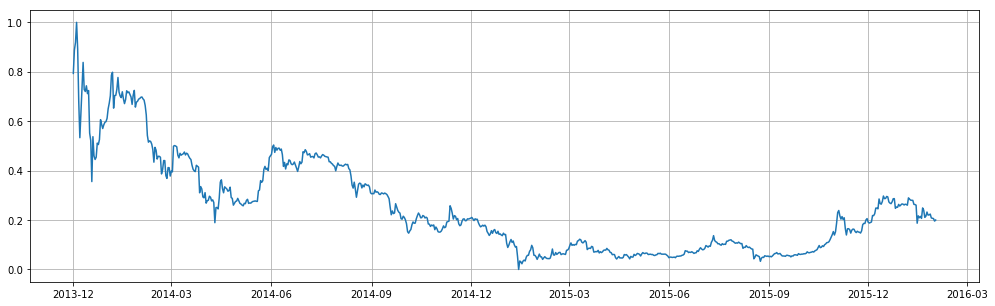

In [120]:

#dataframe = pd.read_csv('ethereum/ether-price.csv')
# bitcoin price data
dataframe = pd.read_csv('bitcoin/bitcoin_price.csv')

dates = pd.to_datetime(dataframe['Date'].values)

dataframe2 = pd.read_csv('bitcoin/bitcoin_price.csv', usecols=[1], engine='python')

dataset = dataframe2.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17,5))
ax.plot(dates, dataset)
plt.grid(True)
plt.show()

In [121]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


531 262


In [122]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=6):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return n.array(dataX), n.array(dataY)

In [123]:
# reshape into X=t and Y=t+1
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX.shape

(524, 6)

In [124]:
import numpy as np
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(524, 1, 6)

In [127]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(9, input_shape=(1, look_back)))

model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 9)                 576       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 10        
Total params: 586
Trainable params: 586
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=5, verbose=2)

Epoch 1/10
10s - loss: 0.0471 - acc: 0.0019
Epoch 2/10
10s - loss: 0.0045 - acc: 0.0019
Epoch 3/10
9s - loss: 0.0019 - acc: 0.0019
Epoch 4/10
9s - loss: 0.0017 - acc: 0.0019
Epoch 5/10
9s - loss: 0.0016 - acc: 0.0019
Epoch 6/10
10s - loss: 0.0016 - acc: 0.0019
Epoch 7/10
11s - loss: 0.0016 - acc: 0.0019
Epoch 8/10
11s - loss: 0.0015 - acc: 0.0019
Epoch 9/10
9s - loss: 0.0015 - acc: 0.0019
Epoch 10/10
10s - loss: 0.0014 - acc: 0.0019


In [129]:
score, acc = model.evaluate(testX, testY, batch_size=20)

240/255 [===========================>..] - ETA: 0s

In [130]:
#prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [131]:

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 35.24 RMSE
Test Score: 15.84 RMSE


In [133]:

#score2 = model.evaluate(trainX[0], trainY[:,0])
#print('Accuracy: %.2f' % (trainAccuracy))

#testAccuracy = accuracy_score(testY2, testPredict2)
#print('Accuracy: %.2f' % (testAccuracy))

In [134]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict



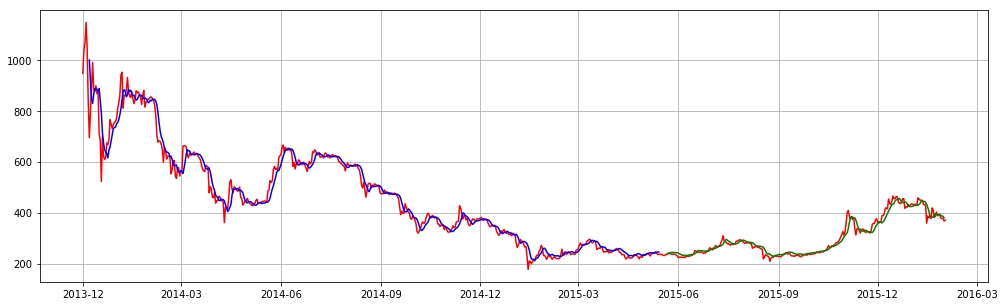

In [135]:
# plot baseline and predictions
import matplotlib.pyplot as plt
#plt.plot(scaler.inverse_transform(dataset))
#plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
#plt.show()

fig, ax = plt.subplots(figsize=(17,5))
ax.plot_date(dates, scaler.inverse_transform(dataset), fmt='r', label='train')
ax.plot_date(dates, trainPredictPlot, fmt='b', label="predict")
ax.plot_date(dates, testPredictPlot, fmt='g', label= "test")
plt.grid(True)
plt.show()

In [175]:
#
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#zscore_comments2016_2013.shape
zscore_2016_2013_btc

dataset = pd.DataFrame(zscore_2016_2013_btc[['zscore_btc']])
dataset['zscore_reply'] =  zscore_comments2016_2013['zscore_reply']
dataset
values = dataset.values

## integer encode direction
# encoder = LabelEncoder()
# values[:,2] = encoder.fit_transform(values[:,2])
# values
## ensure all data is float
values = values.astype('float32')

## normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
## frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
## drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())

In [176]:
reframed


,var1(t-1),var2(t-1),var1(t),var2(t)
1,-0.196493,-0.327057,-0.113879,-0.375258
2,-0.113879,-0.375258,-0.131215,0.620639
3,-0.131215,0.620639,-0.135386,1.555614
4,-0.135386,1.555614,-0.070650,1.774301
5,-0.070650,1.774301,-0.159601,1.440000
6,-0.159601,1.440000,-0.183600,1.118808
7,-0.183600,1.118808,-0.030941,0.554818
8,-0.030941,0.554818,0.016731,0.725968
9,0.016731,0.725968,-0.205377,0.757471
10,-0.205377,0.757471,-0.161497,0.969495


In [177]:
dataset


,zscore_btc,zscore_reply
788,-0.196493,-0.327057
787,-0.113879,-0.375258
786,-0.131215,0.620639
785,-0.135386,1.555614
784,-0.070650,1.774301
783,-0.159601,1.440000
782,-0.183600,1.118808
781,-0.030941,0.554818
780,0.016731,0.725968
779,-0.205377,0.757471


In [178]:

# split into train and test sets
values = reframed.values
n_train_hours = 690
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(690, 1, 3) (690,) (98, 1, 3) (98,)


In [179]:
# design network
model1 = Sequential()
model1.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dense(1))
model1.compile(loss='mae', optimizer='adam')
# fit network
model1.fit(train_X, train_y, epochs=10, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

Train on 690 samples, validate on 98 samples
Epoch 1/10
137s - loss: 0.6446 - val_loss: 1.2196
Epoch 2/10
136s - loss: 0.4041 - val_loss: 0.7574
Epoch 3/10
137s - loss: 0.3606 - val_loss: 0.5548
Epoch 4/10
136s - loss: 0.3582 - val_loss: 0.5098
Epoch 5/10
136s - loss: 0.3573 - val_loss: 0.5017
Epoch 6/10
133s - loss: 0.3557 - val_loss: 0.4904
Epoch 7/10
135s - loss: 0.3560 - val_loss: 0.4990
Epoch 8/10
132s - loss: 0.3551 - val_loss: 0.5016
Epoch 9/10
133s - loss: 0.3546 - val_loss: 0.5027
Epoch 10/10
134s - loss: 0.3547 - val_loss: 0.5041


In [181]:
# make a prediction
yhat = model1.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yyhathat))
#print('Test RMSE: %.3f' % rmse)

In [222]:
yhat = yhat.reshape((yhat.shape[0], yhat.shape[1]))
#yhat[:,0].shape
#calculate RMSE
rmse = Math.qrt(mean_squared_error(test_y, yhat[:,0]))
#print('Test RMSE: %.3f' % rmse)

NameError: name 'Math' is not defined